Descargando y extrayendo imágenes de prueba desde https://github.com/MatiasAni23/Modelos-Deep-Learning/archive/refs/heads/main.zip …
Imágenes extraídas en 'Modelos-Deep-Learning-main/test_imgs'
Cargando y preprocesando imágenes…
  → 40 imágenes cargadas, shape: (40, 784)

Descargando modelo 'Cambio_10_mejor_ultima_epoca' …
Modelo 'Cambio_10_mejor_ultima_epoca' guardado en Cambio_10_mejor_ultima_epoca.h5
Cargando modelo 'Cambio_10_mejor_ultima_epoca'…


Evaluando modelo 'Cambio_10_mejor_ultima_epoca' …

--- Resultados para modelo 'Cambio_10_mejor_ultima_epoca' ---
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000         4
           1     0.0000    0.0000    0.0000         4
           2     0.8000    1.0000    0.8889         4
           3     0.5714    1.0000    0.7273         4
           4     1.0000    1.0000    1.0000         4
           5     0.8000    1.0000    0.8889         4
           6     1.0000    1.0000    1.0000         4
           7     0.6667    0.5000    0.5714         4
           8     1.0000    0.7500    0.8571         4
           9     0.6000    0.7500    0.6667         4

    accuracy                         0.8000        40
   macro avg     0.7438    0.8000    0.7600        40
weighted avg     0.7438    0.8000    0.7600        40


Mostrando grid 5×8 de V vs P para las primeras 40 imágenes…


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


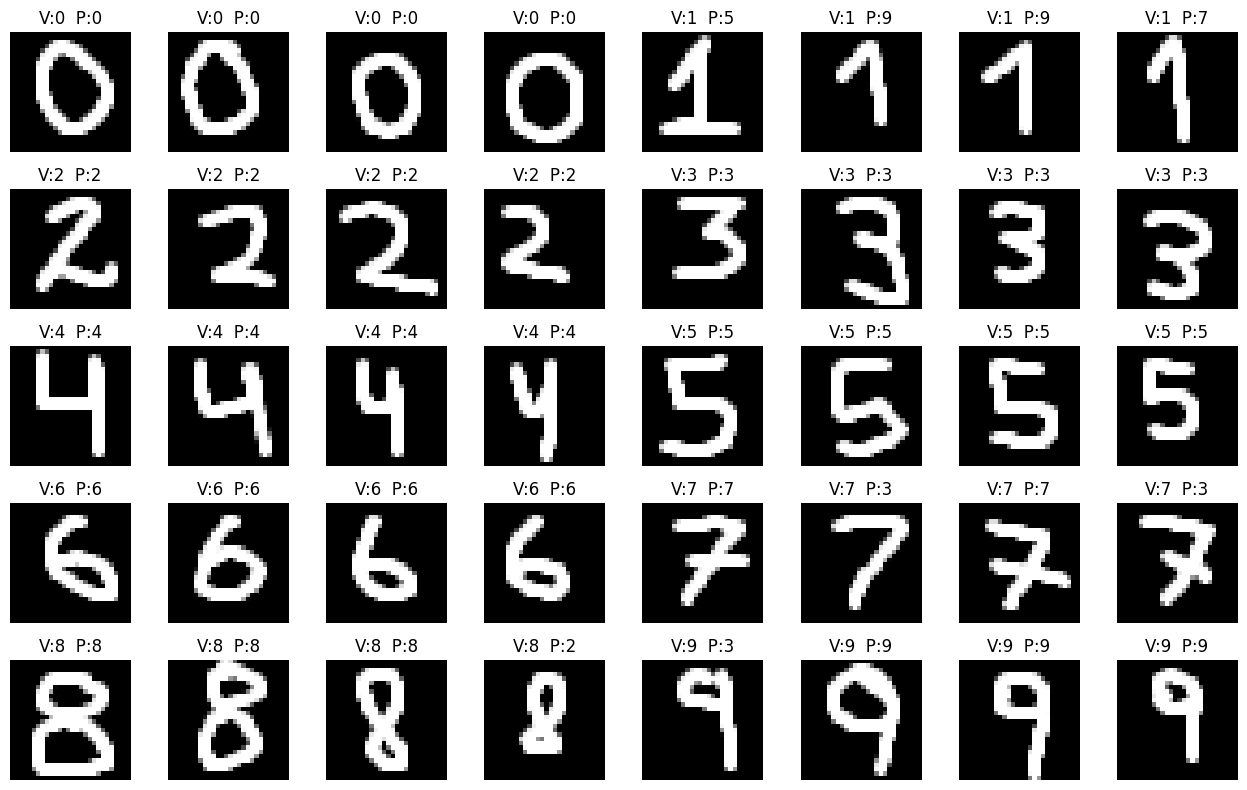

In [ ]:
import os
import io
import zipfile
import requests
from PIL import Image
import numpy as np
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# -------------------------------
# 1. Descargar y extraer test_imgs desde GitHub
# -------------------------------
REPO_ZIP_URL = 'https://github.com/MatiasAni23/Modelos-Deep-Learning/archive/refs/heads/main.zip'
REPO_DIR     = 'Modelos-Deep-Learning-main'
IMG_DIR      = os.path.join(REPO_DIR, 'test_imgs')

if not os.path.isdir(IMG_DIR):
    print(f"Descargando y extrayendo imágenes de prueba desde {REPO_ZIP_URL} …")
    r = requests.get(REPO_ZIP_URL, stream=True)
    r.raise_for_status()
    with zipfile.ZipFile(io.BytesIO(r.content)) as z:
        z.extractall()
    print(f"Imágenes extraídas en '{IMG_DIR}'")
else:
    print(f"Ya existe el directorio de imágenes: '{IMG_DIR}'")

# -------------------------------
# 2. Preprocesar imágenes
# -------------------------------
print("Cargando y preprocesando imágenes…")
X_list, y_list = [], []
for fname in sorted(os.listdir(IMG_DIR)):
    if not fname.lower().endswith('.png'):
        continue
    etiqueta = int(fname.split('_')[0])
    img = Image.open(os.path.join(IMG_DIR, fname)).convert('L')
    img = img.resize((28, 28))
    arr = np.array(img, dtype=np.float32) / 255.0
    # invertir colores si el fondo es claro
    if arr.mean() > 0.5:
        arr = 1.0 - arr
    X_list.append(arr.flatten())
    y_list.append(etiqueta)

X = np.stack(X_list).astype('float32')  # (n_samples, 784)
y_true = np.array(y_list)
print(f"  → {X.shape[0]} imágenes cargadas, shape: {X.shape}")

# -------------------------------
# 3. Definir modelos a probar
# -------------------------------
model_urls = {
    #'cambio7_11': 'https://raw.githubusercontent.com/MatiasAni23/Modelos-Deep-Learning/main/modelo_cambio7_11.h5',
    'Cambio_10_mejor_ultima_epoca': 'https://raw.githubusercontent.com/MatiasAni23/Modelos-Deep-Learning/main/Cambio_10_mejor_ultima_epoca.h5',
}

# -------------------------------
# 4. Bucle: descargar, cargar y evaluar cada modelo
# -------------------------------
for name, url in model_urls.items():
    model_path = f"{name}.h5"
    if not os.path.exists(model_path):
        print(f"\nDescargando modelo '{name}' …")
        r = requests.get(url, stream=True)
        r.raise_for_status()
        with open(model_path, 'wb') as f:
            for chunk in r.iter_content(8192):
                f.write(chunk)
        print(f"Modelo '{name}' guardado en {model_path}")
    else:
        print(f"\nModelo '{name}' ya encontrado en disco.")

    print(f"Cargando modelo '{name}'…")
    model = load_model(model_path)
    # Compilar para construir las métricas y evitar el warning de ABSEIL
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    print(f"Evaluando modelo '{name}' …")
    probs  = model.predict(X, verbose=0)
    y_pred = np.argmax(probs, axis=1)

    print(f"\n--- Resultados para modelo '{name}' ---")
    print(classification_report(y_true, y_pred, digits=4))

# -------------------------------
# 5. Visualizar primeras 40 predicciones en un grid 5×8
# -------------------------------
print("\nMostrando grid 5×8 de V vs P para las primeras 40 imágenes…")
num_display = min(40, X.shape[0])
cols = 8
rows = (num_display + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(cols * 1.6, rows * 1.6))
axes = axes.flatten()

for i in range(num_display):
    axes[i].imshow(X[i].reshape(28, 28), cmap='binary_r')
    axes[i].set_title(f"V:{y_true[i]}  P:{y_pred[i]}")
    axes[i].axis('off')

# Ocultar ejes sobrantes
for j in range(num_display, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()
